## Mask R-CNN - Train on Vanitas Dataset

This notebook shows how to train Mask R-CNN on your own dataset. We use the Vanitas image dataset. You need a GPU.

The code of the Vanitas dataset is included below. It generates images on the fly, so it doesn't require downloading any data. And it can generate images of any size

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
import os
os.chdir('drive/MyDrive/fine_art_asssociations_meanings-ryan-vision/vision')
!python setup.py install
!pip3 install --upgrade tensorflow
!pip install --upgrade keras

running install
running bdist_egg
running egg_info
writing mask_rcnn.egg-info/PKG-INFO
writing dependency_links to mask_rcnn.egg-info/dependency_links.txt
writing top-level names to mask_rcnn.egg-info/top_level.txt
reading manifest file 'mask_rcnn.egg-info/SOURCES.txt'
writing manifest file 'mask_rcnn.egg-info/SOURCES.txt'
installing library code to build/bdist.linux-x86_64/egg
running install_lib
running build_py
creating build/bdist.linux-x86_64/egg
creating build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/utils.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/parallel_model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/config.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/__init__.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/model.py -> build/bdist.linux-x86_64/egg/mrcnn
copying build/lib/mrcnn/visualize.py -> build/bdist.linux-x86_64/egg/mrcnn
byte-compiling build/bdist.linux-x86_64/egg/mrcnn/utils.p

In [4]:
import json
import os
import sys
import random
import math
import re
import time

import skimage
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

import tensorflow as tf
print(tf.__version__)

# Root directory of the project
ROOT_DIR = os.path.abspath('../')

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

# Set directory for the Vanitas dataset.
VANITAS_DIR = os.path.join(ROOT_DIR, "data/vanitas_json")
print(VANITAS_DIR)

2.5.0
/content/drive/My Drive/fine_art_asssociations_meanings-ryan-vision/data/vanitas_json


## Configuration

In [5]:
class VanitasConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "vanitas"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1

    # Number of classes (including background)
    NUM_CLASSES = 1 + 35  # Background + Vanitas keys

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9
    
config = VanitasConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                48
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE         

## Notebook Preferences

In [6]:

def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax


Dataset

Create a synthetic dataset

Extend the Dataset class and add a method to load the vanitas dataset, load_vanitas(), and override the following methods:

- load_image()
- load_mask()
- image_reference()

In [7]:
class VanitasDataset(utils.Dataset):

    def load_vanitas(self, dataset_dir, subset):
        """Load a subset of the vanitas dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """

        # Add classes.

        keys = ['Skull', 'Hourglass', 'Globe', 'Coins', 'Butterfly ', 'Flowers', 'Watch', 'Dice', 'Fruit', 'violin',
                'Lute', 'Flute', 'Candle', 'Inkstand', 'Music', 'Bubble', 'Lamp', 'Book', 'Glass', 'Goblet', 'Vase',
                'Crown', 'Bishop\'s mitre', 'Bishop\'s Mitre', 'Crab', 'Lobster', 'Seashells', 'Chicken', 'Atlas',
                'Clock', 'Fish', 'Smoke', 'Bread', 'Wine', 'sea shells']

        for i in range(len(keys)):
            self.add_class('vanitas', i + 1, keys[i])

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        directory_list = os.listdir(dataset_dir)
        annotations = []
        for file in directory_list:
            if file[-5:] == '.json':
                annotations.append(json.load(open(os.path.join(dataset_dir, file))))

        # Add images
        for a in annotations:
            # Get the x, y coordinates of points of the polygons that make up
            # the outline of each object instance. These are stored in the
            # shape_attributes (see json format above)
            filename = a['asset']['name']
            image_path = os.path.join(dataset_dir, filename)
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]
            if type(a['regions']) is dict:
                polygons = [r['boundingBox'] for r in a['regions'].values()]
                tags = [r['tags'] for r in a['regions'].values()]
            else:
                polygons = [r['boundingBox'] for r in a['regions']]
                tags = [r['tags'] for r in a['regions']]

            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.

            self.add_image("vanitas",
                image_id=filename,  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons, labels=tags)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a semiotics dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "vanitas":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])], dtype=np.uint8)

        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.rectangle((int(p['top']), int(p['left'])), ((int(p['top'])+int(p['height'])), (int(p['left'])+int(p['width']))))
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance.
        class_ids = np.zeros([mask.shape[-1]], dtype=np.int32)

        keys = ['Skull', 'Hourglass', 'Globe', 'Coins', 'Butterfly ', 'Flowers', 'Watch', 'Dice', 'Fruit', 'violin',
                'Lute', 'Flute', 'Candle', 'Inkstand', 'Music', 'Bubble', 'Lamp', 'Book', 'Glass', 'Goblet', 'Vase',
                'Crown', 'Bishop\'s mitre', 'Bishop\'s Mitre', 'Crab', 'Lobster', 'Seashells', 'Chicken', 'Atlas',
                'Clock', 'Fish', 'Smoke', 'Bread', 'Wine', 'sea shells']

        for i in range(len(info["labels"])):
            for j in range(len(keys)):
                if info["labels"][i][0] == keys[j]:
                    class_ids[i] = j + 1
                    continue
        return mask.astype(np.bool), class_ids

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "vanitas":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


In [8]:
# Training dataset
dataset_train = VanitasDataset()
dataset_train.load_vanitas(VANITAS_DIR, 'train')
dataset_train.prepare()

# Validation dataset
dataset_val = VanitasDataset()
dataset_val.load_vanitas(VANITAS_DIR, 'val')
dataset_val.prepare()

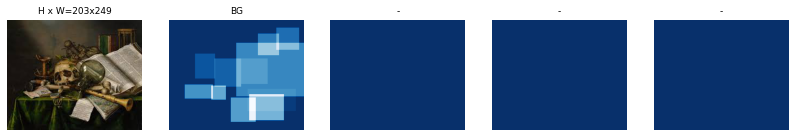

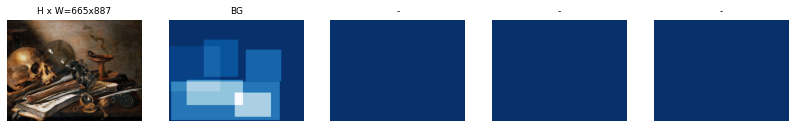

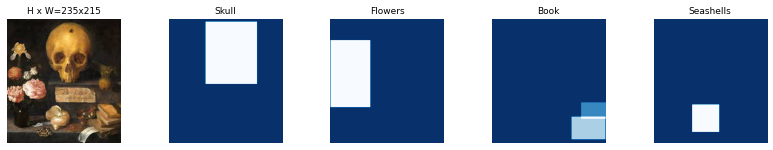

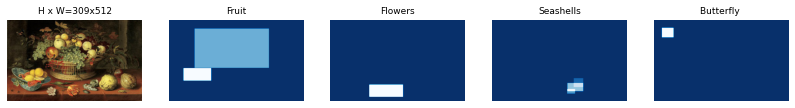

In [9]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

## Create Model

In [10]:
config = VanitasConfig()
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config, model_dir=MODEL_DIR)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.


In [11]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)


## Training

Train in two stages:

1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass layers='heads' to the train() function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass layers="all to train all layers.

In [ ]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: /content/drive/My Drive/fine_art_asssociations_meanings-ryan-vision/logs/vanitas20210803T0022/mask_rcnn_vanitas_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
rpn_model              (Functional)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)
mrcnn_mask_bn4         (TimeDistributed)
mrcnn_bbox_fc 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: UserWarning: Converting sparse IndexedSlices(IndexedSlices(indices=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/sub:0", shape=(None,), dtype=int32), values=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/GatherV2_2:0", shape=(None, 7, 7, 256), dtype=float32), dense_shape=Tensor("training/SGD/gradients/gradients/roi_align_classifier/concat_grad/Shape:0", shape=(4,), dtype=int32))) to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "shape. This may consume a large amount of memory." % value)
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/indexed_slices.py:449: U

 12/100 [==>...........................] - ETA: 46:03 - batch: 5.5000 - size: 1.0000 - loss: 8.9613 - rpn_class_loss: 0.1001 - rpn_bbox_loss: 0.4529 - mrcnn_class_loss: 2.0835 - mrcnn_bbox_loss: 1.0354 - mrcnn_mask_loss: 0.8088

In [ ]:

# Fine tune all layers
# Passing layers="all" trains all layers. You can also 
# pass a regular expression to select which layers to
# train by name pattern.
model.train(dataset_train, dataset_val, 
            learning_rate=config.LEARNING_RATE / 10,
            epochs=2, 
            layers="all")

In [ ]:

# Save weights
# Typically not needed because callbacks save after every epoch
# Uncomment to save manually
# model_path = os.path.join(MODEL_DIR, "mask_rcnn_shapes.h5")
# model.keras_model.save_weights(model_path)

## Detection

In [ ]:
class InferenceConfig(VanitasConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

In [ ]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

In [ ]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

## Evaluation

In [ ]:

# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
image_ids = np.random.choice(dataset_val.image_ids, 10)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))